In [24]:
from qiskit.quantum_info import Statevector, Pauli
from qiskit.opflow import I, Z, PauliOp
import numpy as np   
import networkx as nx  
import matplotlib.pyplot as plt

Below is an example 3-reg graph with 4 nodes.

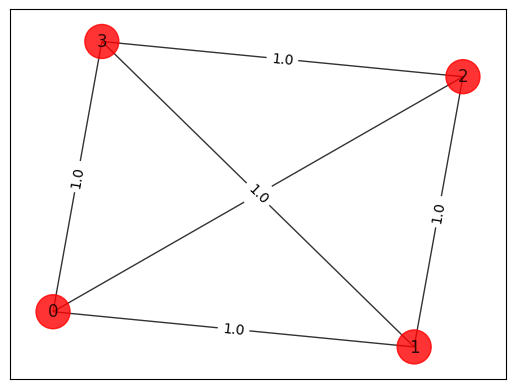

In [108]:
G = nx.Graph()

G.add_weighted_edges_from([(0,1,1.0),(0,2,1.0),(0,3,1.0),(1,2,1.0),(1,3,1.0),(2,3,1.0)])
labelmap = dict(zip(G.nodes(), ["0", "1", "2", "3"]))

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

We have the following Hamiltonian, representing the connections between the vertices in the graph.

In [109]:
H_cut = (Z^Z^I^I) + (Z^I^Z^I) + (I^Z^Z^I) + (Z^I^I^Z) + (I^Z^I^Z) + (I^I^Z^Z)

For all potential cuts, we can compute the expectation value:

In [110]:
print("Assignment : Value")
for n in range(0, 16):
    psi=Statevector.from_int(n, dims=16)
    print('{0:04b}'.format(n), ":", psi.expectation_value(H_cut))

Assignment : Value
0000 : (6+0j)
0001 : 0j
0010 : 0j
0011 : (-2+0j)
0100 : 0j
0101 : (-2+0j)
0110 : (-2+0j)
0111 : 0j
1000 : 0j
1001 : (-2+0j)
1010 : (-2+0j)
1011 : 0j
1100 : (-2+0j)
1101 : 0j
1110 : 0j
1111 : (6+0j)


Any cut with an exp_val of -2 is a max cut, for example, 0011:

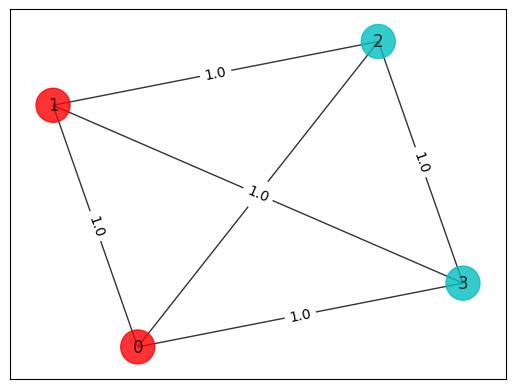

In [124]:
colors = ["r","r","c","c"]
draw_graph(G, colors, pos)

We can define our graphs recursively to build larger ones. These graphs are similar to Cayley graphs, but they branch and connect the leaf nodes such that we retain the 3-regularity of the graph. 

The graph above is the graph given by the below code when n=1. (n=0 is a trivial case where we have just one unconnected node)

Due the exponentially increasing size of this graph plus the amount of space needed to allocate memory for a quantum Statevector, our computer can only handle up to n=2. For n=2, our graph has 10 nodes, therefore requiring 10 qubits. For n=3, we have k=22 vertices, requiring 22 qubits, which is at the upper limit of what a classical computer can simulate.

In [137]:
n = 1 # Hausdorff dimension

ks = [1,4]
for i in range(0,n+5):
    ks.append(ks[-1] + 6*(2**(len(ks)-2)))
k=ks[n]
print(ks)
print("k:", k)

[1, 4, 10, 22, 46, 94, 190, 382]
k: 4


In [138]:
edges = [[0,1,1.0],[0,2,1.0],[0,3,1.0]]
vertices = [[0],[1,2,3]]

if n==1:
    edges.append([1,2,1.0])
    edges.append([2,3,1.0])
    edges.append([3,1,1.0])
    
for i in range(1,n):
    #print("n:", i)
    leaves = [l for l in range(ks[i], ks[i+1])]
    vertices.append(leaves)
    #print('leaves:')
    #print(vertices)
    
    vert_chunks = list(zip(*[iter(vertices[j+1])] * 2))

    # Connect vertices to new leaves
    for vc in range(0,len(vert_chunks)):
        for v in vert_chunks[vc]:
            edges.append([vertices[i][vc],v,1.0])
    
    if i==n-1:
        # Connect leaves to each other *only for outer leaves*
        for l in range(leaves[0],leaves[-1]):
            #print([l,(l%leaves[-1])+1])
            edges.append([l,(l%leaves[-1])+1,1.0])
        #print([leaves[-1],leaves[0]])
        edges.append([leaves[-1],leaves[0],1.0])
#edges

In [139]:
labels = [str(i) for i in range(0,k)]
#labels

In [140]:
print(k)

4


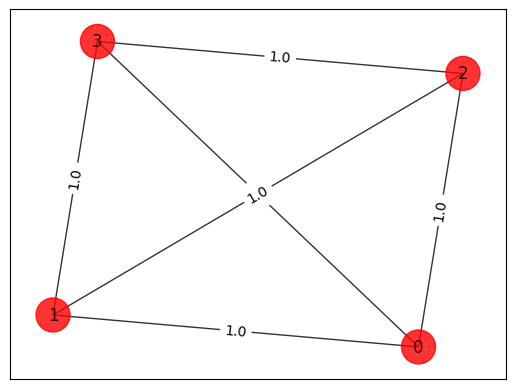

In [141]:
import numpy as np   
import networkx as nx  
import matplotlib.pyplot as plt

G = nx.Graph()

G.add_weighted_edges_from(edges)
#labelmap = dict(zip(G.nodes(), labels))

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)


In [123]:
for i in G.degree():
    if(i[1] != 3):
        print("Not a 3-reg graph.")
        break

Let's now make the Hamiltonian and find the MaxCut

In [85]:
word = Pauli("ZZI")
word2 = Pauli("ZII")
H_cut = PauliOp(word) 
H_cut += PauliOp(word2)
H_cut

/tmp/ipykernel_514/2953531878.py:3: DeprecationWarning: The class ``qiskit.opflow.primitive_ops.pauli_op.PauliOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  H_cut = PauliOp(word)
/tmp/ipykernel_514/2953531878.py:4: DeprecationWarning: The class ``qiskit.opflow.primitive_ops.pauli_op.PauliOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  H_cut += PauliOp(word2)


PauliSumOp(SparsePauliOp(['ZZI', 'ZII'],
              coeffs=[1.+0.j, 1.+0.j]), coeff=1.0)

In [86]:

init_str = ""
for c in range(0,k):
    if c in edges[0]:
        init_str += "Z"
    else:
        init_str += "I"
H_cut = PauliOp(Pauli(init_str))


for edge in edges[1:]:
    _str = ""
    for c in range(0,k):
        if c in edge:
            _str += "Z"
        else:
            _str += "I"
    print(_str)
    H_cut += PauliOp(Pauli(_str))
    print(edge)

ZIZI
[0, 2]
ZIIZ
[0, 3]
IZZI
[1, 2]
IIZZ
[2, 3]
IZIZ
[3, 1]


/tmp/ipykernel_514/3473452247.py:7: DeprecationWarning: The class ``qiskit.opflow.primitive_ops.pauli_op.PauliOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  H_cut = PauliOp(Pauli(init_str))
/tmp/ipykernel_514/3473452247.py:18: DeprecationWarning: The class ``qiskit.opflow.primitive_ops.pauli_op.PauliOp`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  H_cut += PauliOp(Pauli(_str))


In [87]:
H_cut

PauliSumOp(SparsePauliOp(['ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IIZZ', 'IZIZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]), coeff=1.0)

In [88]:
print(2**k)

16


In [89]:
exp_vals = []
for n in range(0, 2**k):
    psi=Statevector.from_int(n, dims=2**k)
    exp_vals.append(('{0:04b}'.format(n), psi.expectation_value(H_cut)))
exp_vals

[('0000', (6+0j)),
 ('0001', 0j),
 ('0010', 0j),
 ('0011', (-2+0j)),
 ('0100', 0j),
 ('0101', (-2+0j)),
 ('0110', (-2+0j)),
 ('0111', 0j),
 ('1000', 0j),
 ('1001', (-2+0j)),
 ('1010', (-2+0j)),
 ('1011', 0j),
 ('1100', (-2+0j)),
 ('1101', 0j),
 ('1110', 0j),
 ('1111', (6+0j))]

In [90]:
res1 = min(list(zip(*exp_vals))[1])
res1

(-2+0j)

In [91]:
for ev in exp_vals:
    if ev[1] == res1:
        print(ev[0])

0011
0101
0110
1001
1010
1100


Let's try running it now using Qiskit's TwoLocal and SamplingVQE:

In [126]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

algorithm_globals.random_seed = 123
seed = 10598

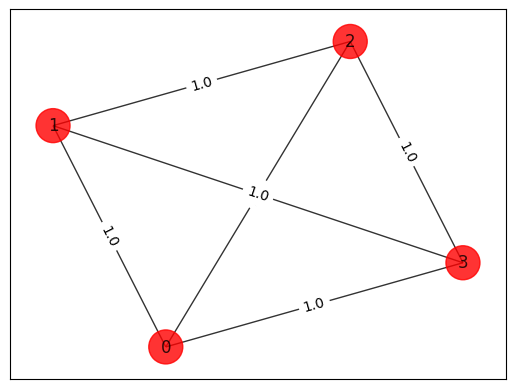

In [147]:
# Generating a graph of 4 nodes

n = 4  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3,1,1.0)]
# tuple is (i,j,weight) where (i,j) is the edge
G.add_weighted_edges_from(elist)

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)


def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


draw_graph(G, colors, pos)

In [149]:
# Computing the weight matrix from the random graph
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp["weight"]
print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [1. 1. 1. 0.]]


In [150]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_1*x_3 - 2*x_2*x_3 + 3*x_0
  + 3*x_1 + 3*x_2 + 3*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3



In [152]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -3.0
Ising Hamiltonian:
0.5 * IIZZ
+ 0.5 * IZIZ
+ 0.5 * IZZI
+ 0.5 * ZIIZ
+ 0.5 * ZIZI
+ 0.5 * ZZII


energy: -0.9999709670773771
time: 2.2867274284362793
max-cut objective: -3.999970967077377
solution: [0 1 1 0]
solution objective: 4.0


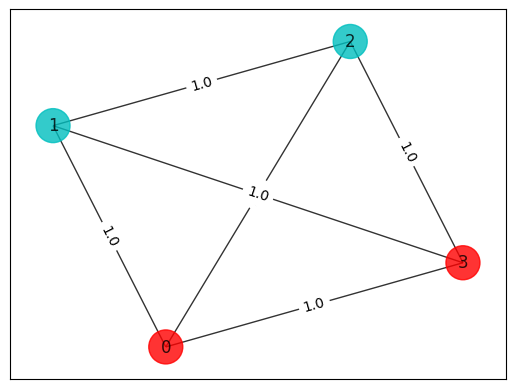

In [186]:
# construct SamplingVQE
optimizer = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=2, entanglement="linear", insert_barriers=True)
vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)

# run SamplingVQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


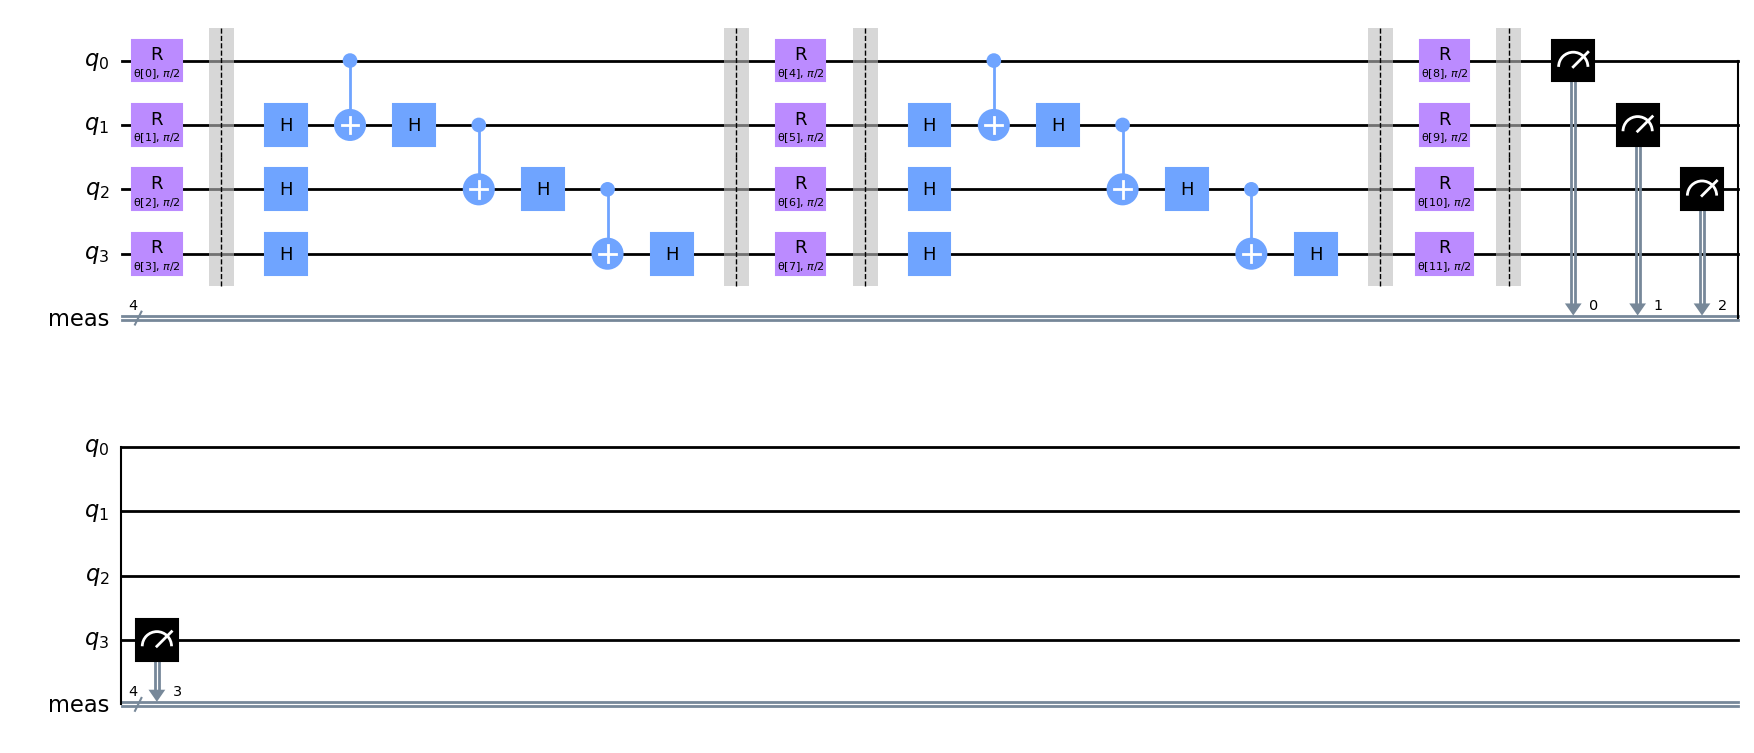

In [187]:
ry.decompose(reps=2).draw('mpl')

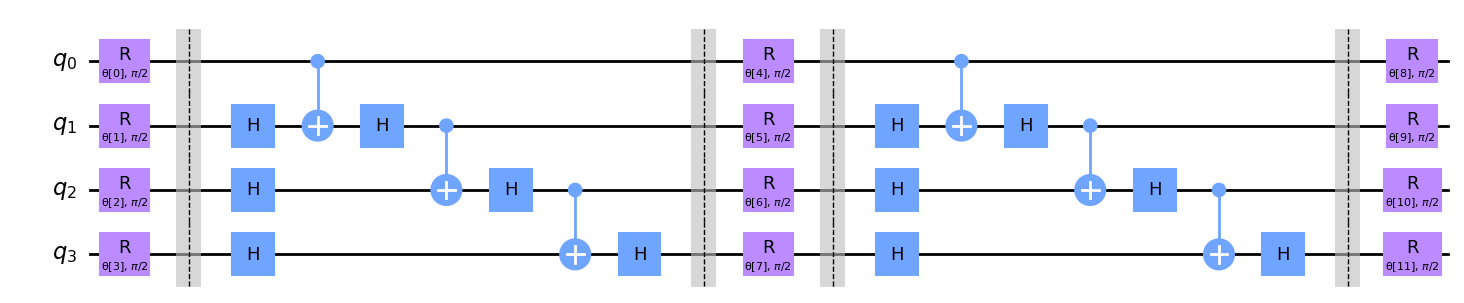

In [188]:
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=2, entanglement="linear", insert_barriers=True)
ry.decompose(reps=2).draw('mpl')

Now let's try cutting the graph. We will switch from using Statevector to using a QuantumCircuit object.

In [161]:
from circuit_knitting.cutting.gate_and_wire_cutting.frontend import cut_wires_and_gates_to_subcircuits
from circuit_knitting.cutting.gate_and_wire_cutting.frontend import execute_simulation
from circuit_knitting.cutting.cutting_reconstruction import reconstruct_expectation_values
from circuit_knitting.cutting.gate_and_wire_cutting.frontend import exact_observables
from circuit_knitting.cutting.gate_and_wire_cutting.frontend import compare_results

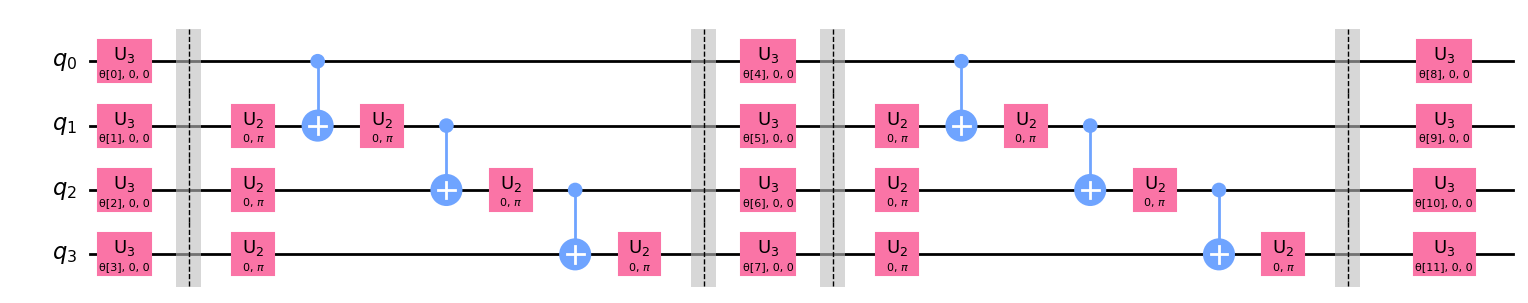

In [189]:
ry =ry.decompose(reps=3)
ry.draw('mpl')

In [190]:
qubitOp

PauliSumOp(SparsePauliOp(['IIZZ', 'IZIZ', 'IZZI', 'ZIIZ', 'ZIZI', 'ZZII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j]), coeff=1.0)

In [191]:
H_cut

PauliSumOp(SparsePauliOp(['ZZII', 'ZIZI', 'IZZI', 'ZIIZ', 'IZIZ', 'IIZZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]), coeff=1.0)

In [192]:
# List out the observables
observables_paulis = H_cut
observables = [str(i)[6:] for i in observables_paulis]
print(f'Observables: {observables}')

Observables: ['ZZII', 'ZIZI', 'IZZI', 'ZIIZ', 'IZIZ', 'IIZZ']


In [196]:
subcircuits, subobservables = cut_wires_and_gates_to_subcircuits(
    circuit=ry,
    observables=observables,
    method='automatic',
    max_subcircuit_width=ry.num_qubits/2,
    max_cuts=100,
    num_subcircuits=[2],
    model='gurobi'
)

Set parameter TimeLimit to value 300
Set parameter Cutoff to value 1e+100
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 157 rows, 75 columns and 502 nonzeros
Model fingerprint: 0xb615aeb8
Variable types: 0 continuous, 75 integer (60 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+02]
  RHS range        [1e+00, 2e+00]
Presolve removed 157 rows and 75 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 1: 2 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.000000000000e+00, best bound 2.000000000000e+00, gap 0.0000%
MIP MODEL CUT EDG

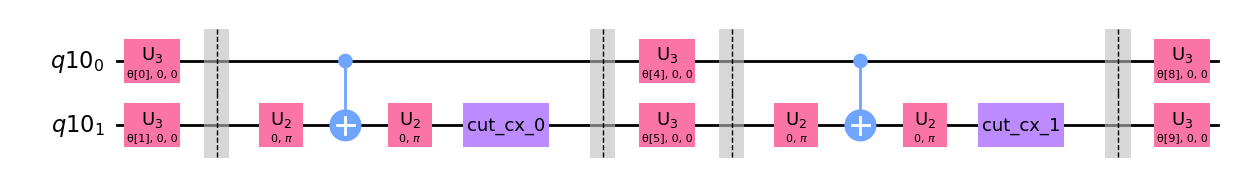

In [197]:
subcircuits[0].draw('mpl')

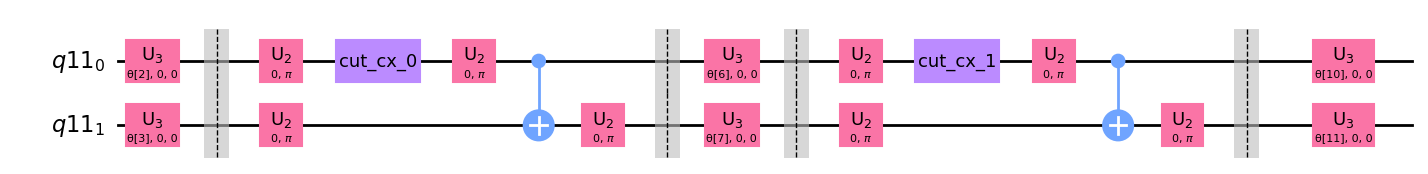

In [198]:
subcircuits[1].draw('mpl')